In [2]:
from nsepy import get_history as nse
import pandas as pd
import numpy as np
import datetime
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

#start and end of data period
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 11, 1)

# get data
stock1=nse(symbol='NIFTY 100',start=start,end=end,index='True') ['Close']
stock=stock1.dropna()
#log of data
#stock=np.log(stock1)

In [3]:
stock

Date
2010-01-04     5153.55
2010-01-05     5203.80
2010-01-06     5214.00
2010-01-07     5191.70
2010-01-08     5175.75
                ...   
2019-10-27    11782.50
2019-10-29    11942.05
2019-10-30    12002.95
2019-10-31    12037.25
2019-11-01    12047.80
Name: Close, Length: 2438, dtype: float64

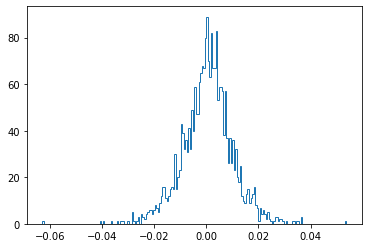

In [4]:
# ret
returns1 = stock.pct_change()
returns=returns1.dropna()
#returns.plot()
#histogram
#hist= returns.hist(bins=500)

#OR
plt.hist(returns,bins=200, histtype='step')
plt.show()


In [5]:

#stats
print("mean = {}".format(np.mean(returns)))
print ("std dev = {}".format(np.std(returns)))
print ("min = {}".format(np.min(returns)))
print ("max = {}".format(np.max(returns)))
print ("skewness = {}".format(returns.skew()))
print ("excess kurtosis = {}".format(returns.kurtosis()))

mean = 0.00039523061664386097
std dev = 0.009662381619433775
min = -0.06299040461334837
max = 0.053752241020937674
skewness = -0.12664081029035973
excess kurtosis = 1.981909075750384


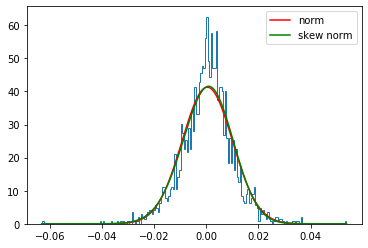

In [6]:
xs=np.linspace(np.min(returns),np.max(returns),200)
#xs=np.linspace(-5,10,200)
#y1=stats.norm.pdf(xs,np.mean(returns),np.std(returns))

ps = stats.norm.fit(returns)
y1= stats.norm.pdf(xs,*ps)
ps = stats.skewnorm.fit(returns)
y2= stats.skewnorm.pdf(xs,*ps)

plt.plot(xs,y1,color='red',label="norm")
plt.plot(xs,y2,color='green',label="skew norm")

plt.hist(returns,bins=200,density='True', histtype='step')
plt.legend()
plt.show()



In [7]:
#Parametric var
p=[.1,.05,.025,.01]
#sigma = np.std(returns, ddof=1)
ps = stats.norm.fit(returns)
for n in p:
    #print(-sigma * stats.norm.ppf(n,*ps) )
    print("the VAR @ {}% = {}".format(n*100, stats.norm.ppf(n,*ps)))
    print("the ES @ {}% = {}".format (n*100,stats.norm.pdf(stats.norm.ppf(n,*ps)) /n))
    #print("ie. daily, there is {}% chance that losses might exceed {} (per 100 unit ccy)".format(n*100, stats.norm.ppf(n,*ps)*(-100)))
    

the VAR @ 10.0% = -0.011987609674630863
the ES @ 10.0% = 3.9891361687268643
the VAR @ 5.0% = -0.015497972835071028
the ES @ 5.0% = 7.977887457422373
the VAR @ 2.5% = -0.018542689362328144
the ES @ 2.5% = 15.954948074770941
the VAR @ 1.0% = -0.022082830321897198
the ES @ 1.0% = 39.884501987943565


In [8]:
#hist VAR
p=[.1,.05,.025,.01]
returns.sort_values(inplace=True,ascending=True)
for n in p:
     print("the hist VAR @ {}% = {}".format(n*100, returns.quantile(n)))

the hist VAR @ 10.0% = -0.011421137102934796
the hist VAR @ 5.0% = -0.016114595714761905
the hist VAR @ 2.5% = -0.019740801685146126
the hist VAR @ 1.0% = -0.02406666260920135


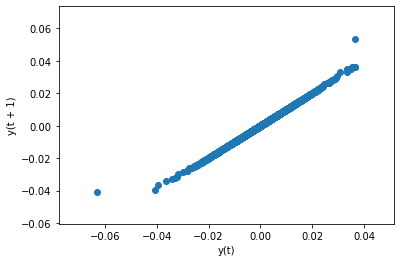

In [9]:
# visualising autocorrelation with lag 1
pd.plotting.lag_plot (returns,lag=1)



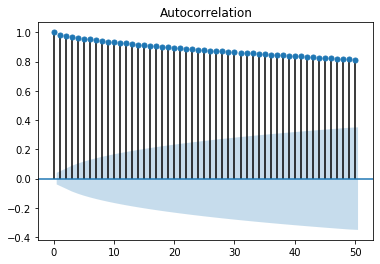

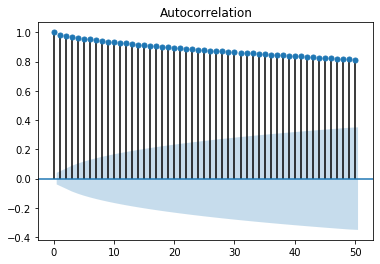

In [10]:


from statsmodels.graphics.tsaplots import plot_acf
plot_acf(returns, lags=50)
#pyplot.show()

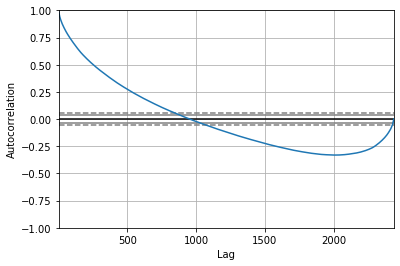

In [11]:
#autocorrelation 
pd.plotting.autocorrelation_plot(returns)

In [22]:
from arch import arch_model 
#scaled returns for the model to work correctly
scaled_ret=returns*1000
am = arch_model(scaled_ret, mean = 'zero', vol='Garch', p=1, o=0, q=1,dist='Normal')
res = am.fit()
omega = res.params[0]
alpha = res.params[1]
beta = res.params[2]
## computing sigma2 for t+1
sigma2 = omega + alpha*returns[-1]**2 + beta * res.conditional_volatility[-1]**2

p=[.1,.05,.025,.01]
for n in p:
    var=np.sqrt(sigma2) * stats.norm.ppf(n)
    print ('GARCH VAR @ {}% = {}'.format(n*100,var))

Iteration:      1,   Func. Count:      5,   Neg. LLF: 7655.427546186501
Iteration:      2,   Func. Count:     11,   Neg. LLF: 7591.914432598246
Iteration:      3,   Func. Count:     16,   Neg. LLF: 7147.177415598089
Iteration:      4,   Func. Count:     27,   Neg. LLF: 7113.876783371731
Iteration:      5,   Func. Count:     32,   Neg. LLF: 7112.079708658645
Iteration:      6,   Func. Count:     38,   Neg. LLF: 7109.565293146354
Iteration:      7,   Func. Count:     44,   Neg. LLF: 7107.548337061605
Iteration:      8,   Func. Count:     50,   Neg. LLF: 7105.8778419826285
Iteration:      9,   Func. Count:     56,   Neg. LLF: 7104.461811578515
Iteration:     10,   Func. Count:     61,   Neg. LLF: 7093.36164719559
Iteration:     11,   Func. Count:     68,   Neg. LLF: 7093.270702856533
Iteration:     12,   Func. Count:     74,   Neg. LLF: 7092.721952886339
Iteration:     13,   Func. Count:     79,   Neg. LLF: 7086.468092620316
Iteration:     14,   Func. Count:     87,   Neg. LLF: 7086.45431

In [17]:
res
#check the 95% CI, if it contains zero
# then H0=> its not significantly diff to zero is true

 

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -7086.42
Distribution:                  Normal   AIC:                           14178.8
Method:            Maximum Likelihood   BIC:                           14196.2
                                        No. Observations:                 2437
Date:                Mon, Dec 09 2019   Df Residuals:                     2434
Time:                        21:39:25   Df Model:                            3
                              Volatility Model                              
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      1.1377e-04  5.794e-05      1.963  4.959e-02 [2.

check the 95% CI, if it contains zero
then H0=> its not significantly diff to zero is true

in our case, omega and alpha are sig diff to zero, while beta isnt.